# LVIS Biomass Modeling
#### This is an R Markdown Notebook. When you execute code within the notebook, the results appear beneath the code.

#### This notebook will use a plot shapefile to search EarthData, and read LVIS granules that intersect the plot
#### LVIS metrics are extracted for the plot and a biomass model is created for the plot.


## Load all the packages required for the LVIS biomass modeling

In [17]:
packages <- c("sp","ggplot2","raster","mapview","maptools","rgdal","leaps","rgeos","gstat","lidR","sf","fs","readr","reticulate")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE)
    }
})

## Read the plot shapefile



In [18]:
#Field data
bona_plot <- read_sf(dsn = './Bona_Data/Shapefile_Bona_Plots/')

## Convert shape to lat/lon and find bounding box

In [19]:
#plot_bbox <- st_bbox(bona_plot)

#expand.grid(plot_bbox[c(1,3)], plot_bbox[c(2,4)])
#str(bona_plot)
#st_crs(plot_bbox)$wkt

plot_geo <- st_transform(bona_plot, 4326)
plot_bbox <- st_bbox(plot_geo)
plot_bbox <- paste(plot_bbox, collapse=",")
plot_bbox

[1] "-147.513387046006,65.1526390998056,-147.494574095586,65.1586758699273"

## Source python script "retrieve_LVIS.py" containing function to retrieve LVIS granules from EarthData

In [20]:
reticulate::import_from_path("maap","../../maap-py/")
reticulate::import_from_path("ipycmc","../../../maap-jupyter-ide/ipycmc/")

#reticulate::import("boto3")
reticulate::source_python("./retrieve_LVIS.py")

Module(maap)

Module(ipycmc)

## Use retrieveLVIS() python function to search for and read LVIS granules within bounding box

In [21]:
lvis_result <- retrieveLVIS(granuleDomain = plot_bbox)
lvis_result <- lvis_result[[1]]

## Convert the LVIS L2 file to the sf object using part of the gridding functions from Paul. Change the epsg code if needed



#### Modified load_lvis2 function for input from earthdata


In [22]:
id_cols = c("LFID", "SHOTNUMBER", "TIME", "GLON", "GLAT", "ZG")
    t_cols  = c("TLON", "TLAT", "ZT")
    h_cols  = c("HLON","HLAT", "ZH")
    rh_metrics = c("RH010", "RH015", "RH020", "RH025", "RH030", "RH035", "RH040", "RH045", "RH050", "RH055", "RH060", "RH065", "RH070", "RH075", "RH080", "RH085", "RH090", "RH095", "RH096", "RH097", "RH098", "RH099", "RH100")
misc_cols = c("AZIMUTH", "INCIDENTANGLE", "RANGE", "COMPLEXITY")
channel_cols = c("CHANNEL_ZT", "CHANNEL_ZG", "CHANNEL_RH")
cols <- c(id_cols, h_cols, t_cols, rh_metrics, misc_cols, "SENSITIVITY", channel_cols)
num_lines_hdr=20

load_lvis2 <- function(lvis2_df, num_lines_hdr, cols, crs) {

  #lvis2_name <- path_ext_remove(path_file(lvis2_txt_path))
  #print(paste("Loading", lvis2_name))
  print(paste0("Skipping lines: ", num_lines_hdr))
  lvis2_df <- py_to_r(lvis2_df)
  lvis2_txt <- read_table(file=lvis2_df[,1], skip=num_lines_hdr, col_names=cols)
  print(head(lvis2_txt))
  lvis2_pts <- lvis2_txt %>%
    #dplyr::filter(!is.na(GLON), !is.na(GLAT)) %>%
    st_as_sf(coords=c("GLON","GLAT"), crs=4326) %>%
    st_transform(crs="+proj=utm +zone=06 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0")
  #attr(lvis2_pts, "lvis2_name") <- lvis2_name
  return(lvis2_pts)
}

##
#test <- load_lvis2(lvis2_txt_path = lvis_result[,1],num_lines_hdr = num_lines_hdr,cols = cols)
lvis_facility <- lapply(X = lvis_result, FUN=load_lvis2, num_lines_hdr = num_lines_hdr,cols = cols)
lvis_facility <- do.call(rbind,lvis_facility)

[1] "Skipping lines: 20"
# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   95399138 85446.  212.  65.1  441.  212.  65.1  461.  212.  65.1  462.
2 1.96e9   95399139 85446.  212.  65.1  440.  212.  65.1  455.  212.  65.1  460.
3 1.96e9   95399140 85446.  212.  65.1  440.  212.  65.1  458.  212.  65.1  461.
4 1.96e9   95399141 85446.  212.  65.1  437.  212.  65.1  453.  212.  65.1  456.
5 1.96e9   95399142 85446.  212.  65.1  437.  212.  65.1  455.  212.  65.1  459.
6 1.96e9   95399143 85446.  212.  65.1  437.  212.  65.1  456.  212.  65.1  458.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH09

## Convert LVIS data (point format) to polygon with radius defined in L2 file.



In [8]:
lvis_facility <- st_buffer(lvis_facility, dist = 5)


## Convert dta format to spatialpolygondataframe

In [9]:
lvis_facility <- as(lvis_facility,'Spatial')

bona_plot <- as(bona_plot, 'Spatial')


## Calculate the overlapped area for all the LVIS-Facility footprints partially or entirely within the plots. Then extract those footprints fully overlapped the plots



In [10]:
within_plot <- raster::intersect(bona_plot,lvis_facility)
within_plot$area <- raster::area(within_plot)

within_plot_updated <- within_plot[which(within_plot$area >= floor(pi*25)),]

## Create the dataframe with all the height metrics (from LVIS L2 file) of those footprints entirely within the plots being averaged



In [11]:
plot_center_x <- unique(within_plot_updated$center_x)
plot_number <- length(unique(within_plot$center_x))

within_plot_updated <- data.frame(within_plot_updated)
plot_level_metrics <- array(data = NA, dim=c(plot_number,26))
colnames(plot_level_metrics) <-  c("center_x","center_y","agbd.ha","RH10","RH15","RH20","RH25","RH30","RH45","RH40","RH45","RH50","RH55","RH60","RH65","RH70","RH75","RH80","RH85","RH90","RH95","RH96","RH97","RH98","RH99","RH100")
for(i in 1: nrow(plot_level_metrics)) {
  plot_level_metrics[i,1] <- mean(within_plot_updated$center_x[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,2] <- mean(within_plot_updated$center_y[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,3] <- mean(within_plot_updated$agbd.ha[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,4] <- mean(within_plot_updated$RH010[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,5] <- mean(within_plot_updated$RH015[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,6] <- mean(within_plot_updated$RH020[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,7] <- mean(within_plot_updated$RH025[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,8] <- mean(within_plot_updated$RH030[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,9] <- mean(within_plot_updated$RH035[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,10] <- mean(within_plot_updated$RH040[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,11] <- mean(within_plot_updated$RH045[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,12] <- mean(within_plot_updated$RH050[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,13] <- mean(within_plot_updated$RH055[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,14] <- mean(within_plot_updated$RH060[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,15] <- mean(within_plot_updated$RH065[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,16] <- mean(within_plot_updated$RH070[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,17] <- mean(within_plot_updated$RH075[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,18] <- mean(within_plot_updated$RH080[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,19] <- mean(within_plot_updated$RH085[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,20] <- mean(within_plot_updated$RH090[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,21] <- mean(within_plot_updated$RH095[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,22] <- mean(within_plot_updated$RH096[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,23] <- mean(within_plot_updated$RH097[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,24] <- mean(within_plot_updated$RH098[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,25] <- mean(within_plot_updated$RH099[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
  plot_level_metrics[i,26] <- mean(within_plot_updated$RH100[which(within_plot_updated$center_x == unique(within_plot_updated$center_x)[i])])
}
plot_level_metrics <- data.frame(plot_level_metrics)

## Extract the lidar variables and create two additional dataframes with all the columns containing negative values (or 0) being filtered before the log- and square root-transformation.



In [12]:
lidar_vars <- c("RH10","RH15","RH20","RH25","RH30","RH45","RH40","RH45","RH50","RH55","RH60","RH65","RH70","RH75","RH80","RH85","RH90","RH95","RH96","RH97","RH98","RH99","RH100")
plot_level_metrics <- data.frame(plot_level_metrics)
predict_data <- plot_level_metrics[,which(names(plot_level_metrics) %in% lidar_vars)]
for(i in 1:nrow(predict_data)) {
  for(j in 1:ncol(predict_data)) {
    if(predict_data[i,j] <= 0) {
      print(paste(j))
    }
  }
}
predict_data_log <- predict_data[,-c(1:10)]
predict_data_log <- apply(predict_data_log,MARGIN = c(1,2),FUN = log)
predict_data_log <- data.frame(predict_data_log)

for(i in 1:nrow(predict_data)) {
  for(j in 1:ncol(predict_data)) {
    if(predict_data[i,j] < 0) {
      print(paste(j))
    }
  }
}
predict_data_square_root <- predict_data[,-c(1:10)]
predict_data_square_root <- apply(predict_data_square_root,MARGIN = c(1,2),FUN = sqrt)

[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "10"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "1"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "10"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "10"
[1] "1"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "1"
[1] "1"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "10"
[1] "1"
[1] "2"
[1] "3"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "1"
[1] "2"
[1] "3"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "1"
[1] "2"
[1] "1"
[1] "2"
[1] "3"
[1] "1"
[1] "2"
[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] 

## Use leap function to find the best predictive variables



In [13]:
ols_leaps_model <- leaps(y=plot_level_metrics$agbd.ha, x=predict_data, method='adjr2', strictly.compatible=FALSE,nbest = 1)
ols_leaps_model_log <- leaps(y=log(plot_level_metrics$agbd.ha), x=predict_data_log, method='adjr2', strictly.compatible=FALSE,nbest=1)
#small_models <- ols_leaps_model[which(ols_leaps_model$size <= 5)]
ols_leaps_model_square_root <-leaps(y=sqrt(plot_level_metrics$agbd.ha),x=predict_data_square_root,method = 'adjr2', strictly.compatible = FALSE,nbest = 1)
ols_leaps_model_normal_log <- leaps(y=plot_level_metrics$agbd.ha, x=predict_data_log, method='adjr2', strictly.compatible=FALSE,nbest = 1)
ols_leaps_model_normal_square_root <- leaps(y=plot_level_metrics$agbd.ha, x=predict_data_square_root, method='adjr2', strictly.compatible=FALSE,nbest = 1)
ols_leaps_model_log_normal <- leaps(y=log(plot_level_metrics$agbd.ha), x=predict_data, method='adjr2', strictly.compatible=FALSE,nbest=1)
ols_leaps_model_log_square_root <- leaps(y=log(plot_level_metrics$agbd.ha), x=predict_data_square_root, method='adjr2', strictly.compatible=FALSE,nbest=1)
ols_leaps_model_square_root_normal<-leaps(y=sqrt(plot_level_metrics$agbd.ha),x=predict_data,method = 'adjr2', strictly.compatible = FALSE,nbest = 1)
ols_leaps_model_square_root_log<-leaps(y=sqrt(plot_level_metrics$agbd.ha),x=predict_data_log,method = 'adjr2', strictly.compatible = FALSE,nbest = 1)

Warning message in log(vr):
“NaNs produced”
Warning message in log(vr):
“NaNs produced”
Warning message in log(vr):
“NaNs produced”


## Determine the best model and predictive variables



ERROR: Error in plot(ols_1, aes(x, y)) + geom_line(aes(color = "OLS_leap")) + : non-numeric argument to binary operator


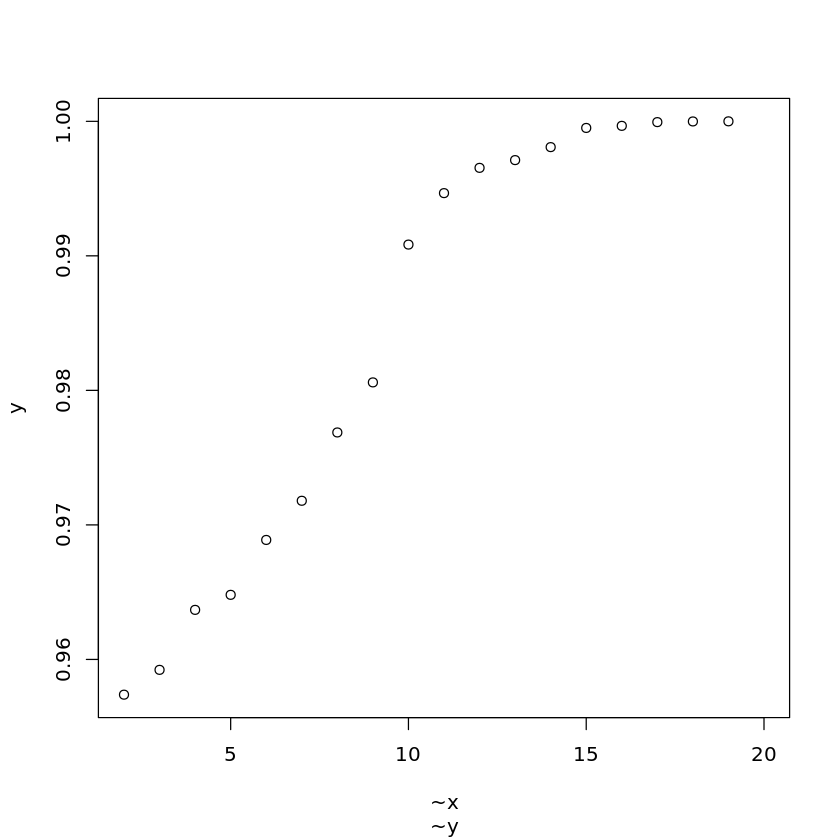

In [14]:
ols_1 <- data.frame(x=ols_leaps_model$size,y=ols_leaps_model$adjr2)
ols_2 <- data.frame(x=ols_leaps_model_square_root$size,y=ols_leaps_model_square_root$adjr2)
ols_3 <- data.frame(x=ols_leaps_model_log$size,y=ols_leaps_model_log$adjr2)
ols_4 <- data.frame(x=ols_leaps_model_normal_log$size,y=ols_leaps_model_normal_log$adjr2)
ols_5 <- data.frame(x=ols_leaps_model_normal_square_root$size,y=ols_leaps_model_normal_square_root$adjr2)
ols_6 <- data.frame(x=ols_leaps_model_log_normal$size,y=ols_leaps_model_log_normal$adjr2)
ols_7 <- data.frame(x=ols_leaps_model_log_square_root$size,y=ols_leaps_model_log_square_root$adjr2)
ols_8 <- data.frame(x=ols_leaps_model_square_root_normal$size,y=ols_leaps_model_square_root_normal$adjr2)
ols_9 <- data.frame(x=ols_leaps_model_square_root_log$size,y=ols_leaps_model_square_root_log$adjr2)
plot(ols_1,aes(x,y))+geom_line(aes(color='OLS_leap'))+geom_line(data = ols_2,aes(color='OLS_leap_square_root'))+geom_line(data = ols_3,aes(color='OLS_leap_log'))+geom_line(data = ols_4,aes(color='OLS_leap_normal_log'))+geom_line(data = ols_5,aes(color='OLS_leap_normal_square_root'))+geom_line(data = ols_6,aes(color='OLS_leap_log_normal'))+geom_line(data = ols_7,aes(color='OLS_leap_log_square_root'))+geom_line(data = ols_8,aes(color='OLS_leap_square_root_normal'))+geom_line(data = ols_9,aes(color='OLS_leap_square_root_log'))+xlab("Number of Variables")+ylab("Adjusted R^2")

## Create the OLS model and make the scatterplots




Call:
lm(formula = agbd.ha ~ RH95, data = plot_level_metrics)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.3560  -5.9269   0.7091   4.5281  20.0856 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.9930     3.8153  -1.833   0.0834 .  
RH95          8.3805     0.4209  19.912 1.04e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.03 on 18 degrees of freedom
Multiple R-squared:  0.9566,	Adjusted R-squared:  0.9542 
F-statistic: 396.5 on 1 and 18 DF,  p-value: 1.04e-13


integer(0)

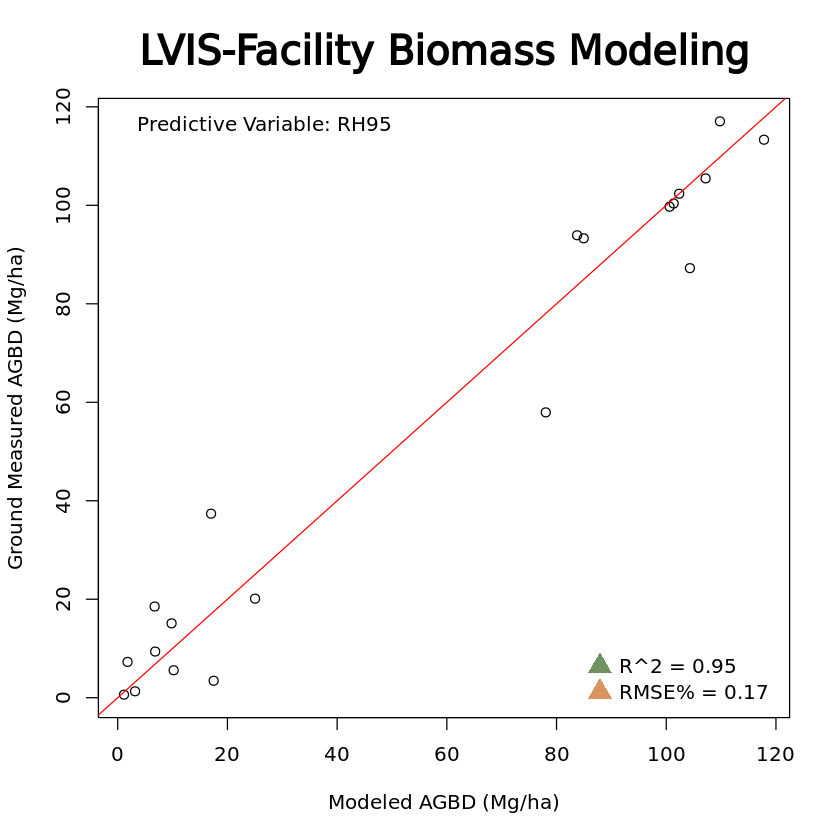

In [15]:
ols_final <- lm(agbd.ha~RH95,data = plot_level_metrics)
summary(ols_final)
plot(ols_final$model$agbd.ha,ols_final$fitted.values,xlab="Modeled AGBD (Mg/ha)",ylab="Ground Measured AGBD (Mg/ha)")+abline(a=0,b=1,col='red')
legend("topleft","Predictive Variable: RH95",pt.cex = 2,bty = "n")
legend("bottomright",legend = c("R^2 = 0.95","RMSE% = 0.17"),col = c(rgb(0.2,0.4,0.1,0.7),rgb(0.8,0.4,0.1,0.7)),pt.cex = 2,bty = "n",pch  =17)
title("LVIS-Facility Biomass Modeling",cex.main=2)

## Use LOOCV to test the robustness of the model



integer(0)

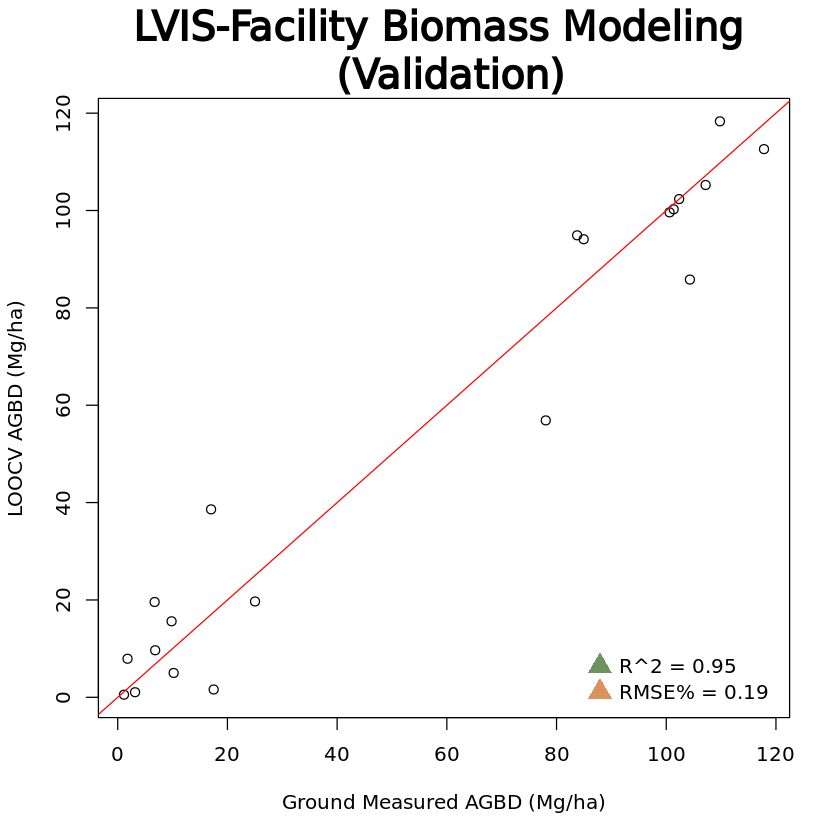

In [16]:
kfold.cv <- function(model.fit, data, k) {
  # Create the folds
  folds <- cut(seq(1,nrow(data)),breaks=k,labels=FALSE)
  folds <- folds[sample(nrow(data), replace=FALSE)]
  
  # Generate predictions
  yhat <- vector(mode="numeric", length=nrow(data))
  for(i in 1:k){
    # Get test and training data
    testindex <- which(folds==i,arr.ind=TRUE)
    testdata <- data[testindex, ]
    traindata <- data[-testindex, ]
    
    # Fit the model and retain predictions
    tmp.model.fit <- update(model.fit, data=traindata)
    yhat[testindex] <- predict(tmp.model.fit, testdata, type="response")
  }
  yhat
}

# Obtaining the CV statistics for OLS model created above
cv_prediction_ols_final <- kfold.cv(ols_final,data = plot_level_metrics, k = nrow(plot_level_metrics))
rmse_cv <- function(x,y){round(sqrt(mean((x-y)^2)),2)}
rsq_cv <- function(x,y){round(summary(lm(y~x))$r.squared, 2)}
rmse_cv_final <- rmse_cv(plot_level_metrics$agbd.ha, cv_prediction_ols_final)/mean(ols_final$model$agbd.ha)
#rrmse_cv_final <- rrmse(plot_level_metrics$agbd.ha, cv_prediction_ols_final)
#Calculate relative RMSE
rrmse_cv_final <- sqrt( mean( (plot_level_metrics$agbd.ha-cv_prediction_ols_final)^2) ) / ( max(cv_prediction_ols_final)-min(cv_prediction_ols_final) )
rrmse_cv_final <- format(rrmse_cv_final*100,digits = 3)
#rsq_cv(plot_level_metrics1$agbd.ha, cv_prediction_ols_final)

plot(ols_final$model$agbd.ha,cv_prediction_ols_final,ylab="LOOCV AGBD (Mg/ha)",xlab="Ground Measured AGBD (Mg/ha)")+abline(a=0,b=1,col='red')
legend("bottomright",legend = c("R^2 = 0.95","RMSE% = 0.19"),col = c(rgb(0.2,0.4,0.1,0.7),rgb(0.8,0.4,0.1,0.7)),pt.cex = 2,bty = "n",pch  =17)
title("LVIS-Facility Biomass Modeling \n (Validation)",cex.main=2)